<a href="https://colab.research.google.com/github/CalebeCaladan/Mapa-Opcoes-Dolar/blob/main/Mapa_Opcoes_Dolar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importando as Bibliotecas**

In [ ]:
!pip install selenium
!pip install webdriver_manager
!apt install chromium-chromedriver
!pip install xlsxwriter

Reading package lists... Done
Building dependency tree       
Reading state information... Done
chromium-chromedriver is already the newest version (89.0.4389.82-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
     |████████████████████████████████| 153kB 9.8MB/s 


In [ ]:
from selenium import webdriver
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

import time
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from webdriver_manager.chrome import ChromeDriverManager

from google.colab import files
import xlsxwriter

In [ ]:
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver', options = options)
driver = webdriver.Chrome('chromedriver', options = options)

## **Vencimento das Opções**

In [ ]:
driver.get('http://www2.bmf.com.br/pages/portal/bmfbovespa/lumis/lum-vencimentos-autorizados-ptBR.asp?cboMercado=3&cboMercadoria=2-DOL')

In [ ]:
dados = driver.find_element_by_id("table_2")
html = dados.get_attribute("innerHTML")
soup = BeautifulSoup(html, "html.parser")
tables = soup.find_all("table") #Pega todas as tabelas

codCall, preco, codPut = [], [], []

table = tables[0].find('tbody') #Pega do Proximo Mês
rows = table.find_all('tr')
for row in rows:
    cols = row.find_all('td')
    codCall.append(cols[1].text.replace("DOL",""))
    preco.append(cols[2].text.replace(".00",""))
    codPut.append(cols[3].text.replace("DOL",""))

callDol1 = pd.DataFrame(list(zip(codCall, preco)), columns = ['Serie','Preço'])
putDol1 = pd.DataFrame(list(zip(codPut, preco)), columns = ['Serie','Preço'])

codCall, preco, codPut = [], [], []

table = tables[1].find('tbody') #Pegou do Outro Mês
rows = table.find_all('tr')
for row in rows:
    cols = row.find_all('td')
    codCall.append(cols[1].text.replace("DOL",""))
    preco.append(cols[2].text.replace(".00",""))
    codPut.append(cols[3].text.replace("DOL",""))

callDol2 = pd.DataFrame(list(zip(codCall, preco)), columns = ['Serie','Preço'])
putDol2 = pd.DataFrame(list(zip(codPut, preco)), columns = ['Serie','Preço'])

## **Posições em Aberto**

In [ ]:
driver.get('http://www2.bmf.com.br/pages/portal/bmfbovespa/lumis/lum-posicoes-em-aberto-opcoes-ptBR.asp')

In [ ]:
dados = driver.find_element_by_xpath("//*[@id='divContainerIframeBmf']/div[6]/div")

html = dados.get_attribute("innerHTML")
soup = BeautifulSoup(html, "html.parser")

table = soup.select_one("table")

codSerie, contratos, variacao = [], [], []
rows = table.find_all('tr')
for row in rows:
    cols = row.find_all('td')
    if len(cols) == 3:
        codSerie.append(cols[0].text)
        contratos.append(cols[1].text.replace(".",""))
        variacao.append(cols[2].text)

series = pd.DataFrame(list(zip(codSerie, contratos, variacao)), columns = ['Serie','N Contratos','Variacao'])

## **Tratamento Dados**

In [ ]:
tabelaCall1 = callDol1.set_index('Serie').join(series.set_index('Serie'))
tabelaPut1 = putDol1.set_index('Serie').join(series.set_index('Serie'))

tabelaCall2 = callDol2.set_index('Serie').join(series.set_index('Serie'))
tabelaPut2 = putDol2.set_index('Serie').join(series.set_index('Serie'))

pd.set_option('display.max_rows', None)
final1 = pd.merge(tabelaCall1, tabelaPut1, on='Preço').sort_values(by='Preço', ascending=False).replace(to_replace = np.nan, value = "0") 
final2 = pd.merge(tabelaCall2, tabelaPut2, on='Preço').sort_values(by='Preço', ascending=False).replace(to_replace = np.nan, value = "0") 

final1['Preço'] = final1['Preço'].str.replace(',', '')

final2['Preço'] = final2['Preço'].str.replace(',', '')

final1 = final1.rename(columns = {'N Contratos_x' : 'Opções compra', 'Variacao_x' : 'Variação compra', 'N Contratos_y' : 'Opções venda', 'Variacao_y' : 'Variação Venda'})
final2 = final2.rename(columns = {'N Contratos_x' : 'Opções compra', 'Variacao_x' : 'Variação compra', 'N Contratos_y' : 'Opções venda', 'Variacao_y' : 'Variação Venda'})

## **Grafico**

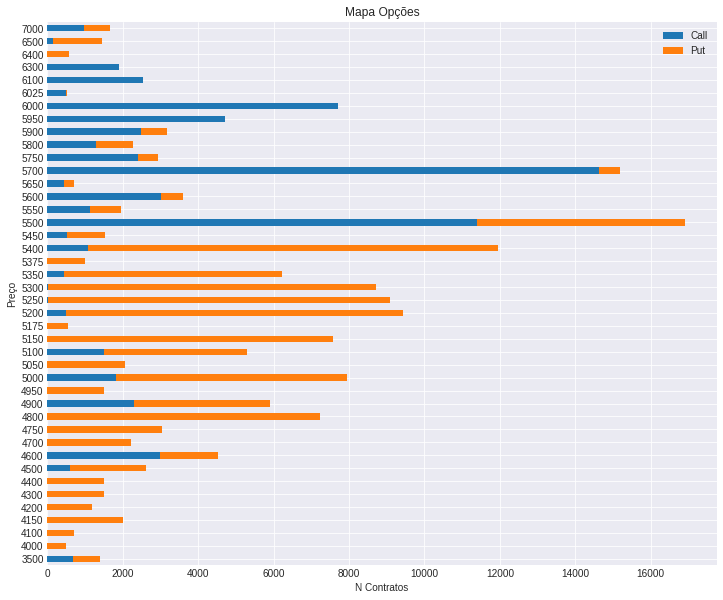

In [ ]:
qtd_compra = final1['Opções compra']
qtd_venda = final1['Opções venda']
preco = final1['Preço']

qtd_compra = list(map(int,qtd_compra.tolist()))
qtd_venda = list(map(int,qtd_venda.tolist()))
preco = list(map(int,preco.tolist()))

df = pd.DataFrame({'Call': qtd_compra, 'Put': qtd_venda}, index=preco)
df = df[(df.T >= 400).any()]

ax = df.plot.barh(figsize=(12,10), stacked=True)
ax.invert_yaxis()
ax.set_ylabel('Preço')
ax.set_xlabel('N Contratos')
ax.set_title('Mapa Opções')

df = df.reset_index()

## **Excel**

In [ ]:
final1 = final1.astype(int)
final1 = final1.loc[(final1['Opções compra'] > 0) | (final1['Opções venda'] > 0) ]

final2 = final2.astype(int)
final2 = final2.loc[(final2['Opções compra'] > 0) | (final2['Opções venda'] > 0) ]

writer = pd.ExcelWriter('tabela_opcoes.xlsx', engine='xlsxwriter')

final1.to_excel(writer, sheet_name='Sheet1')
final2.to_excel(writer, sheet_name='Sheet1', startcol=7)

writer.save()

files.download('tabela_opcoes.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>